In [1]:

# Set up notebook
%pprint
%matplotlib inline
import sys
import os.path as osp, os as os

executable_path = sys.executable
scripts_folder = osp.join(osp.dirname(executable_path), 'Scripts'); assert osp.exists(scripts_folder)
py_folder = osp.abspath(osp.join(os.pardir, 'py')); assert osp.exists(py_folder), "Create the py folder"
ffmpeg_folder = r'C:\ffmpeg\bin'; assert osp.exists(ffmpeg_folder)
shared_folder = osp.abspath(osp.join(os.pardir, 'share')); assert osp.exists(shared_folder)

if (scripts_folder not in sys.path): sys.path.insert(1, scripts_folder)
if (py_folder not in sys.path): sys.path.insert(1, py_folder)
if (ffmpeg_folder not in sys.path): sys.path.insert(1, ffmpeg_folder)
if shared_folder not in sys.path: sys.path.insert(1, shared_folder)

from notebook_utils import NotebookUtilities
nu = NotebookUtilities(
    data_folder_path=osp.abspath(osp.join(os.pardir, 'data')),
    saves_folder_path=osp.abspath(osp.join(os.pardir, 'saves'))
)
nu.delete_ipynb_checkpoint_folders()

from pathlib import Path
root = Path(Path(os.sep).resolve().drive + os.sep)

# Import needed libraries
import re
import pandas as pd
import pyperclip
import ipywidgets as widgets
from IPython.display import display
import inspect

Pretty printing has been turned OFF


In [2]:

# Get a hand-valued dictionary of font sizes for each country
fontsize_dict = {
    'Iran': 140,
    'Turkey': 82,
    'Iraq': 76,
    'Egypt': 60,
    'Yemen': 50,
    'Saudi Arabia': 46,
    'Oman': 36,
    'Syria': 36,
    'Jordan': 18,
    'Israel': 8,
    'Kuwait': 8,
    'United Arab Emirates': 6,
    'Lebanon': 5,
    'Qatar': 4,
    'Bahrain': 1,
}


## Get some good country colors

In [3]:

# Helper function to move a point slightly toward a destination point by a given factor
import numpy as np

def move_point_toward(target_point, destination_point, factor):
    """
    Move a point slightly toward a destination point by a given factor.

    Args:
        target_point (np.ndarray): The point to move (e.g., black or white point).
        destination_point (np.ndarray): The fixed point to move toward.
        factor (float): The proportion of the distance to move.

    Returns:
        np.ndarray: The new position of the target point.
    """
    return target_point + factor * (destination_point - target_point)

In [4]:

# Write a function to spread the color points evenly away from the ocean so that the country colors stand out
def spread_points_in_cube(num_points, fixed_point, cube_size=1.0, iterations=1000, step_size=0.01, contrast_factor=0.1):
    """
    Spread points in a unit cube to maximize the minimum distance between them using a repulsion-based method.
    Moves black (0, 0, 0) and white (1, 1, 1) points slightly toward the fixed point for better contrast.

    Args:
        num_points (int): Total number of points needed (excluding black and white adjustment points).
        fixed_point (tuple): The fixed point in the cube (e.g., (0.529, 0.808, 0.922)).
        cube_size (float): Size of the cube (default is 1.0 for a unit cube).
        iterations (int): Number of optimization iterations.
        step_size (float): Step size for moving points based on forces.
        contrast_factor (float): Factor determining how far black and white points are moved toward the fixed point.

    Returns:
        np.ndarray: Array of shape (num_points, 3) containing the final point positions, excluding the black and white points.
    """
    
    # Ensure the fixed point is not black or white
    assert fixed_point != (0.0, 0.0, 0.0), "The fixed point cannot be black (0.0, 0.0, 0.0)."
    assert fixed_point != (1.0, 1.0, 1.0), "The fixed point cannot be white (1.0, 1.0, 1.0)."

    # Add 2 extra points for black and white
    total_points = num_points + 2
    
    # Initialize points randomly within the cube
    points = np.random.rand(total_points, 3) * cube_size
    points[0] = np.array(fixed_point)  # Set the fixed point
    points[-2] = np.array([0.0, 0.0, 0.0])  # Add black point
    points[-1] = np.array([1.0, 1.0, 1.0])  # Add white point

    # Move black and white points slightly toward the fixed point for contrast
    fixed_point_np = np.array(fixed_point)
    points[-2] = move_point_toward(points[-2], fixed_point_np, contrast_factor)  # Move black point
    points[-1] = move_point_toward(points[-1], fixed_point_np, contrast_factor)  # Move white point

    for _ in range(iterations):
        forces = np.zeros_like(points)  # Store net forces on each point

        for i in range(total_points):
            if i == 0:  # Skip the fixed point
                continue
            for j in range(total_points):
                if i != j:
                    
                    # Compute Euclidean distance
                    diff = points[i] - points[j]
                    dist = np.linalg.norm(diff)
                    if dist > 1e-6:  # Avoid division by zero
                        
                        # Compute repulsion force (inverse-square law)
                        force = diff / (dist**3)
                        forces[i] += force

        # Update positions of all points except the fixed one
        points[1:] += step_size * forces[1:]

        # Ensure points remain within the cube
        points = np.clip(points, 0, cube_size)

    # Remove black and white points from the final result
    return points[:-2]

In [5]:

# Take some 3D points, one of which must be sky blue, and spread them evenly through a unit cube so that they have maximum space between
fixed_point = (0.529, 0.808, 0.922)
num_points = len(fontsize_dict)
spread_points = spread_points_in_cube(num_points, fixed_point)

In [6]:

# Prepare colors for the pie chart and 3D scatter plot
colors = [tuple(color) for color in spread_points]  # Convert spread points to RGB tuples

nu.get_nearest_neighbor(fixed_point, colors[1:])

AssertionError: Mismatched dimensions: 3 != 3

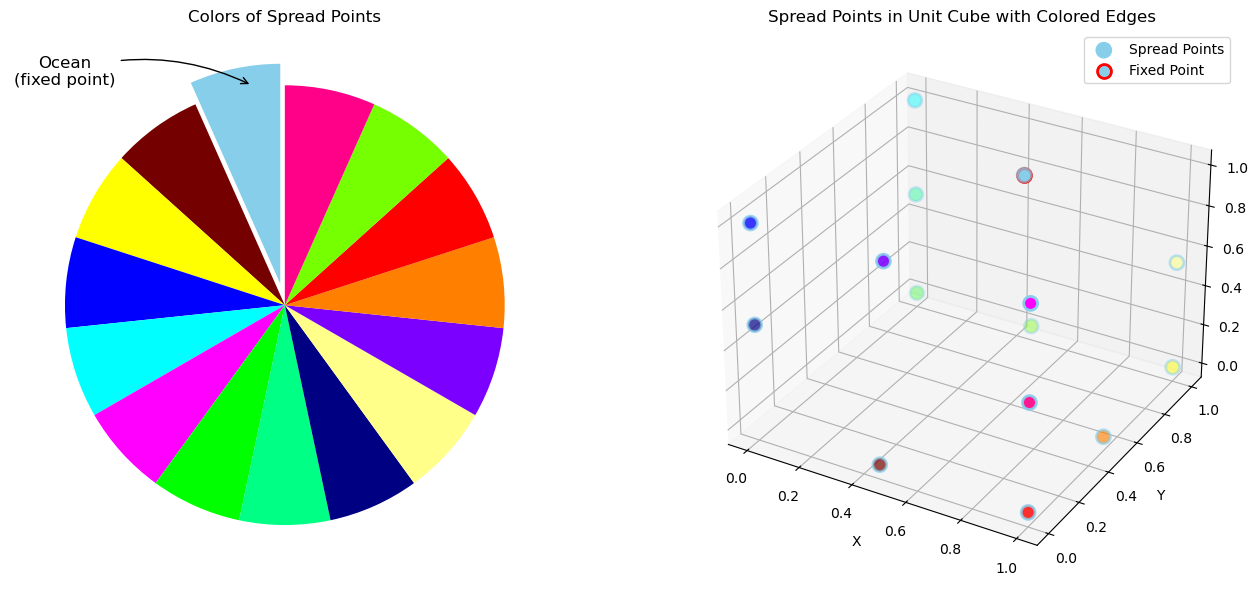

In [7]:

# Create a pie chart and 3D scatter plot showing the colors of the spread points and their distribution in color space
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a figure with two subplots
fig = plt.figure(figsize=(14, 6))

# Left panel: Pie chart
ax1 = fig.add_subplot(121)  # 1 row, 2 columns, 1st subplot
ax1.pie(
    [1 for _ in range(num_points)], 
    colors=colors, 
    explode=[0.1] + [0.0] * (num_points - 1),
    startangle=90, 
)

# Add a curved arrow annotation pointing to the exploded wedge
ax1.annotate(
    'Ocean\n(fixed point)',  # Text label
    arrowprops=dict(
        arrowstyle="->",
        connectionstyle="arc3,rad=-0.2",
        facecolor='black',
    ),  # Arrow style
    fontsize=12,
    ha='center',
    xy=(-0.15, 1),  # Arrow tip location (near the exploded wedge)
    xytext=(-1, 1.0),  # Text location
)

# Add title and adjust aspect ratio
ax1.set_title("Colors of Spread Points")
ax1.set_aspect("equal")

# Right panel: 3D scatter plot
ax2 = fig.add_subplot(122, projection="3d")  # 1 row, 2 columns, 2nd subplot
ax2.scatter(
    spread_points[:, 0], spread_points[:, 1], spread_points[:, 2],
    c=colors, s=100, edgecolors=fixed_point, linewidth=2, label='Spread Points'
)

# Highlight the fixed point with a red edge
ax2.scatter(
    fixed_point[0], fixed_point[1], fixed_point[2],
    c=[fixed_point], s=100, edgecolors='red', linewidth=2, label='Fixed Point'
)
ax2.set_title("Spread Points in Unit Cube with Colored Edges")
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.legend()

# Display the combined plot
plt.tight_layout()
plt.show()

In [24]:

# Convert the dictionary from RGBA to Hex
def rgba_to_hex(rgba):
    r = int(rgba[0] * 255)
    g = int(rgba[1] * 255)
    b = int(rgba[2] * 255)
    return f'#{r:02x}{g:02x}{b:02x}'

# Move the ocean to the front of the list
countries_list = ['Ocean'] + country_names

# Create a separate hex color dictionary for use in the cartogram
hex_color_dict = {key: rgba_to_hex(value) for key, value in zip(countries_list, spread_points)}
hex_color_dict['Ocean'] = '#87ceeb'
hex_color_dict

{'Ocean': '#87ceeb', 'Bahrain': '#ff88ff', 'Egypt': '#00ff82', 'Iran': '#005100', 'Iraq': '#00ff00', 'Israel': '#00ffff', 'Jordan': '#ff0000', 'Kuwait': '#0000ff', 'Lebanon': '#000080', 'Oman': '#8600ff', 'Qatar': '#0080ff', 'Saudi Arabia': '#00af00', 'Syria': '#ff8e00', 'Turkey': '#ff00ff', 'United Arab Emirates': '#ffff00', 'Yemen': '#ff0071'}


## Get some Wikipedia and Natural Earth data

In [2]:

# Retrieve tables from Wikipedia as a list of data frames
tables_url = 'https://en.wikipedia.org/wiki/'
tables_url += 'List_of_Middle_Eastern_countries_by_population'
page_tables_list = nu.get_page_tables(tables_url, verbose=True)

[(0, (16, 10)), (1, (13, 2))]


In [3]:

# Download all the vector and raster map data from Natural Earth
import geopandas as gpd

# Read in the zip file of everything
file_path = osp.abspath(osp.join(nu.data_folder, 'zip', 'ne_10m_admin_0_countries.zip'))
countries_df = gpd.read_file(file_path)

In [4]:

# Clean up the Wikipedia table data create a population dictionary
populations_df = page_tables_list[0].copy()
populations_df.columns = [
    'population_rank', 'country_name', 'projection_2020', 'population_percentage', 'annual_growth_percent', 'annual_growth_absolute',
    'doubling_time_years', 'official_population', 'last_figure_date', 'figure_source'
]
populations_df = populations_df.iloc[:-1]
populations_dict = populations_df.set_index('country_name').official_population.to_dict()

In [5]:

# Add the population column to the natural earth data frame
countries_df['official_population'] = countries_df.NAME_EN.map(lambda x: populations_dict.get(x))

In [7]:

# Get a tupled list of (convex) country boundary areas
country_names = sorted(fontsize_dict.keys())
mask_series = countries_df.NAME_EN.isin(country_names)
country_areas = []
for (country_name, geometry, official_population), df in countries_df[mask_series].groupby(['NAME_EN', 'geometry', 'official_population']):
    bounds_tuple = geometry.bounds
        
    # Bounds Breakdown:
    minx = bounds_tuple[0]
    miny = bounds_tuple[1]
    maxx = bounds_tuple[2]
    maxy = bounds_tuple[3]
    
    # Rectangle Parameters:
    width = maxx - minx
    height = maxy - miny

    # Boundary area creation
    country_area = width * height
    
    area_tuple = (country_name, country_area, official_population)
    country_areas.append(area_tuple)
country_areas = sorted(country_areas, key=lambda x: x[1], reverse=True)
country_areas

[('Saudi Arabia', 331.7788232081368, 34719418.0), ('Iran', 284.01399394254867, 79336000.0), ('Turkey', 120.20356206680844, 83614362.0), ('Egypt', 117.98247035326742, 98154000.0), ('Yemen', 82.57279020407178, 29719300.0), ('Iraq', 81.33432328579566, 40575000.0), ('Oman', 76.64253424717411, 4939200.0), ('Syria', 33.34787577668872, 21377000.0), ('Jordan', 18.1596585328054, 10248069.0), ('United Arab Emirates', 16.627817659608485, 9154000.0), ('Israel', 6.422839435348814, 9100000.0), ('Kuwait', 2.9734908882563205, 4259500.0), ('Lebanon', 2.455264542634866, 6830600.0), ('Qatar', 1.3850950067221495, 2412483.0), ('Bahrain', 0.31085804838628295, 1701000.0)]


## First cartogram attempt

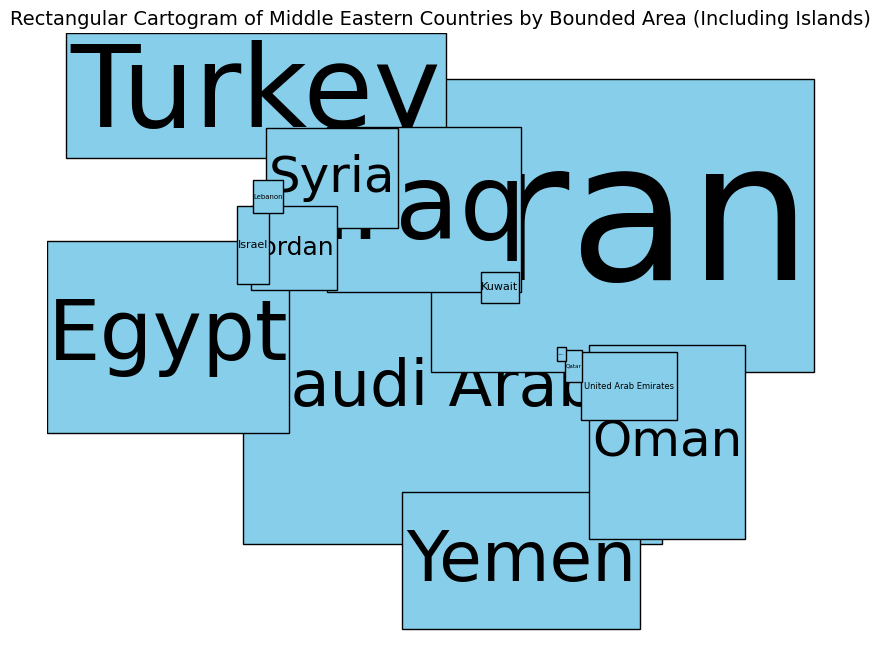

In [8]:

# Create a rectangular cartogram of middle eastern countries by bounded area (including islands)
import matplotlib.patches as patches

# Create the cartogram
fig, ax = plt.subplots(figsize=(12, 8))

# Initialize a base zorder for rectangles
base_zorder = 1

# Loop through countries and their properties
for (country_name, country_area, official_population) in country_areas:
    mask_series = countries_df.NAME_EN.isin([country_name])
    for (country_name, geometry), df in countries_df[mask_series].groupby(['NAME_EN', 'geometry']):
        bounds_tuple = geometry.bounds
            
        # Bounds Breakdown:
        minx = bounds_tuple[0]
        miny = bounds_tuple[1]
        maxx = bounds_tuple[2]
        maxy = bounds_tuple[3]
        
        # Rectangle Parameters:
        lower_left_corner = (minx, miny)
        width = maxx - minx
        height = maxy - miny
        
        # Add rectangle with current zorder
        rect = patches.Rectangle(
            lower_left_corner, width, height,
            edgecolor="black",
            facecolor="skyblue",
            zorder=base_zorder,  # Current zorder for rectangle
        )
        ax.add_patch(rect)
    
        # Add country name with higher zorder than the rectangle
        ax.text(
            minx + width / 2, miny + height / 2, country_name,
            alpha=1.0,
            fontsize=fontsize_dict[country_name],
            ha="center",
            va="center",
            zorder=base_zorder + 1,  # Higher than the current rectangle
        )

        # Increment base zorder for the next rectangle
        base_zorder += 1

# Adjust plot limits
mask_series = countries_df.NAME_EN.isin(country_names)
xlim_minx = countries_df[mask_series].geometry.map(lambda g: g.bounds[0]).min()
xlim_maxx = countries_df[mask_series].geometry.map(lambda g: g.bounds[2]).max()
ax.set_xlim(xlim_minx, xlim_maxx+1)
ylim_miny = countries_df[mask_series].geometry.map(lambda g: g.bounds[1]).min()
ylim_maxy = countries_df[mask_series].geometry.map(lambda g: g.bounds[3]).max()
ax.set_ylim(ylim_miny-1, ylim_maxy)
ax.set_aspect("equal")
plt.title("Rectangular Cartogram of Middle Eastern Countries by Bounded Area (Including Islands)", fontsize=14)
plt.axis("off")
plt.show()


## Second cartogram attempt

In [9]:

# Get the name of the smallest country by convex bounded area
smallest_country = min(country_areas, key=lambda x: x[1])[0]

# Get the smallest country width and height
mask_series = countries_df.NAME_EN.isin([smallest_country])
for (country_name, geometry), df in countries_df[mask_series].groupby(['NAME_EN', 'geometry']):
    bounds_tuple = geometry.bounds
    
    # Bounds Breakdown:
    smallest_country_minx = bounds_tuple[0]
    smallest_country_miny = bounds_tuple[1]
    smallest_country_maxx = bounds_tuple[2]
    smallest_country_maxy = bounds_tuple[3]
    
    # Rectangle Parameters:
    smallest_country_width = smallest_country_maxx - smallest_country_minx
    smallest_country_height = smallest_country_maxy - smallest_country_miny

    # Print the bits for the whole and loop through the parts
    print(country_name, smallest_country_width, smallest_country_height, bounds_tuple, sep='\t')
    for geom in geometry.geoms:
        bounds_tuple = geom.bounds
        
        # Bounds Breakdown:
        minx = bounds_tuple[0]
        miny = bounds_tuple[1]
        maxx = bounds_tuple[2]
        maxy = bounds_tuple[3]
        
        # Rectangle Parameters:
        width = maxx - minx
        height = maxy - miny

        # Display the bits for each geom in the country
        print(' '*len(country_name), width, height, bounds_tuple, sep='\t')

Bahrain	0.43934560475753415	0.7075478735193883	(50.38052953694196, 25.579890923319237, 50.81987514169949, 26.287438796838625)
       	0.19675597118155963	0.45304362000001674	(50.44890384200005, 25.789536851000037, 50.64565981318161, 26.242580471000053)
       	0.04293607712382652	0.054743498332886276	(50.38052953694196, 26.119988096055685, 50.42346561406578, 26.17473159438857)
       	0.08479875231956413	0.08479875231956413	(50.59950353027349, 26.20264004451906, 50.68430228259305, 26.287438796838625)
       	0.06328429875490826	0.1512494740242225	(50.73760555331811, 25.579890923319237, 50.80088985207302, 25.73114039734346)
       	0.01582107468873062	0.010758330788334547	(50.775576132571054, 25.745062943069538, 50.791397207259784, 25.755821273857872)
       	0.01771960365137204	0.015188231701177557	(50.80215553804812, 25.66405904066326, 50.81987514169949, 25.67924727236444)
       	0.03164214937745413	0.02214950456421505	(50.78506877738429, 25.630518362323162, 50.81671092676174, 25.652

In [10]:

# Get the (convex) bounded height and width of all countries together
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry.polygon import Polygon

# Loop through the geometry of all our countries
polygons = []
mask_series = countries_df.NAME_EN.isin(country_names)
for country_multipolygon in countries_df[mask_series].geometry:

    # If the country's geometry is just one geom, append it to the list
    if isinstance(country_multipolygon, Polygon):
        polygons.append(country_multipolygon)

    # Otherwise, use the geoms iterator to break up the mult-polygon into individual geoms
    else:
        polygons.extend(country_multipolygon.geoms)

# Create a new geom from the individual polygons
countries_multipolygon = MultiPolygon(polygons)

# Get the bounds of the new geom
countries_bounds = countries_multipolygon.bounds

# Bounds Breakdown:
countries_minx = countries_bounds[0]
countries_miny = countries_bounds[1]
countries_maxx = countries_bounds[2]
countries_maxy = countries_bounds[3]

# Rectangle Parameters:
countries_width = countries_maxx - countries_minx
countries_height = countries_maxy - countries_miny

print('All Countries', countries_width, countries_height, countries_bounds, sep='\t')

All Countries	38.6312854009999	29.987337970999988	(24.688342732000137, 12.111443672000064, 63.31962813300004, 42.09878164300005)


In [11]:

# Get a data frame of all unit-pixels of the map grid and their polygons
import math
from pandas import DataFrame

# Get the lower left-hand corner of the map
smallest_country_unit = math.ceil(max(smallest_country_width, smallest_country_height))
all_unit = math.ceil(max(countries_width, countries_height))
all_count = int(all_unit/smallest_country_unit)
countries_llc = (math.floor(countries_minx), math.floor(countries_miny))

# Loop through the x- and y-units and build the rows list of the data frame
polygons = []
rows_list = []
for x_unit in range(1, all_count+1):
    for y_unit in range(1, all_count+1):

        # Get all four corners of the grid cell to build the linear ring of the polygon
        llc = (countries_llc[0]+x_unit*smallest_country_unit, countries_llc[1]+y_unit*smallest_country_unit)
        lrc = (countries_llc[0]+(x_unit+1)*smallest_country_unit, countries_llc[1]+y_unit*smallest_country_unit)
        ulc = (countries_llc[0]+x_unit*smallest_country_unit, countries_llc[1]+(y_unit+1)*smallest_country_unit)
        urc = (countries_llc[0]+(x_unit+1)*smallest_country_unit, countries_llc[1]+(y_unit+1)*smallest_country_unit)
        linear_ring = (llc, ulc, urc, lrc, llc)

        # Create the polygon and add it to the row at its xy coordinates
        polygon = Polygon(shell=linear_ring)
        polygons.append(polygon)
        rows_list.append({
            'x_unit': x_unit,
            'y_unit': y_unit,
            'polygon': polygon,
        })

# Create the mult-polygon and data frame
all_polygons = MultiPolygon(polygons)
all_polygons_df = DataFrame(rows_list)

In [66]:

# Function to get the largest polygon
def get_largest_polygon(geometry):
    if isinstance(geometry, MultiPolygon):
        return max(geometry.geoms, key=lambda g: g.area)
    return geometry

In [67]:

# Get the geometry of each country in a dictionary
geometry_dict = {}

# Get the area of each country in a dictionary
area_dict = {}

# For each country, get the coordinates of the grid it intersects with
mask_series = countries_df.NAME_EN.isin(country_names)
rows_list = []
for (country_name, geometry), df in countries_df[mask_series].groupby(['NAME_EN', 'geometry']):

    # Get the largest polygon
    geometry = get_largest_polygon(geometry)

    geometry_dict[country_name] = geometry
    area_dict[country_name] = geometry.area
    for row_index, row_series in all_polygons_df.iterrows():
        x_unit = row_series.x_unit
        y_unit = row_series.y_unit
        polygon = row_series.polygon
        if polygon.intersects(geometry):
            # print(country_name, polygon.bounds, 'intersects', geometry.bounds)
            rows_list.append({
                'x_unit': x_unit,
                'y_unit': y_unit,
                'country_name': country_name,
            })
intersections_df = DataFrame(rows_list)

In [68]:

# Give precedence to the smallest country
srs = intersections_df.groupby('country_name').size().sort_values()
assert not (srs == 1).any(), f"{smallest_country} must been given precedence"

# Remove the intersections that compete with the smallest country
precedence_mask = (intersections_df.country_name == smallest_country)
remove_indices = []
for row_index, row_series in intersections_df[precedence_mask].iterrows():
    x_unit = row_series.x_unit
    y_unit = row_series.y_unit
    mask_series = (intersections_df.x_unit == x_unit) & (intersections_df.y_unit == y_unit) & (intersections_df.country_name != smallest_country)
    remove_indices.extend(intersections_df[mask_series].index.tolist())
mask_series = intersections_df.index.isin(remove_indices)
intersections_df = intersections_df[~mask_series]

In [69]:

# Loop through the duplicate intersections
groupby_columns = ['x_unit', 'y_unit']
mask_series = intersections_df.duplicated(subset=groupby_columns, keep=False)
remove_indices = []
for (x_unit, y_unit), df in intersections_df[mask_series].groupby(groupby_columns):

    # Get the country with the largest area in the unit
    mask_series = (all_polygons_df.x_unit == x_unit) & (all_polygons_df.y_unit == y_unit)
    polygon_unit = all_polygons_df[mask_series].polygon.tolist()[0]
    plurality_country = max(df.country_name, key=lambda x: geometry_dict[x].intersection(polygon_unit).area)

    # Mark the losers for removal
    precedence_mask = (intersections_df.country_name == plurality_country)
    mask_series = (intersections_df.x_unit == x_unit) & (intersections_df.y_unit == y_unit) & (intersections_df.country_name != plurality_country)
    remove_indices.extend(intersections_df[mask_series].index.tolist())
    
# Remove the intersection losers by their indices
mask_series = intersections_df.index.isin(remove_indices)
intersections_df = intersections_df[~mask_series]

In [70]:

# Assert that there are no more duplicate intersections
mask_series = intersections_df.duplicated(subset=groupby_columns, keep=False)
assert not mask_series.any()

In [16]:

# Merge the country grid data frame with the polygon grid data frame
merge_df = all_polygons_df.merge(intersections_df, on=groupby_columns, how='left')
merge_df.country_name = merge_df.country_name.fillna('Ocean')
merge_df.sample(5)

,x_unit,y_unit,polygon,country_name
556,15,11,"POLYGON ((39 23, 39 24, 40 24, 40 23, 39 23))",Saudi Arabia
939,25,4,"POLYGON ((49 16, 49 17, 50 17, 50 16, 49 16))",Yemen
1153,30,23,"POLYGON ((54 35, 54 36, 55 36, 55 35, 54 35))",Iran
496,13,29,"POLYGON ((37 41, 37 42, 38 42, 38 41, 37 41))",Turkey
397,11,8,"POLYGON ((35 20, 35 21, 36 21, 36 20, 35 20))",Ocean


In [17]:

# Assert we still have the same number of countries
assert merge_df.country_name.unique().shape[0] == len(['Ocean'] + country_names)

In [29]:

# Figure out how to get Jordan more convex and contiguous
mask_series = (merge_df.country_name == 'Jordan')
display(merge_df[mask_series])
mask_series = (merge_df.x_unit == 13) & (merge_df.y_unit == 19)
display(merge_df[mask_series])
merge_df.loc[mask_series, 'country_name'] = 'Jordan'

,x_unit,y_unit,polygon,country_name
406,11,17,"POLYGON ((35 29, 35 30, 36 30, 36 29, 35 29))",Jordan
407,11,18,"POLYGON ((35 30, 35 31, 36 31, 36 30, 35 30))",Jordan
408,11,19,"POLYGON ((35 31, 35 32, 36 32, 36 31, 35 31))",Jordan
446,12,18,"POLYGON ((36 30, 36 31, 37 31, 37 30, 36 30))",Jordan
447,12,19,"POLYGON ((36 31, 36 32, 37 32, 37 31, 36 31))",Jordan
485,13,18,"POLYGON ((37 30, 37 31, 38 31, 38 30, 37 30))",Jordan
487,13,20,"POLYGON ((37 32, 37 33, 38 33, 38 32, 37 32))",Jordan
526,14,20,"POLYGON ((38 32, 38 33, 39 33, 39 32, 38 32))",Jordan


,x_unit,y_unit,polygon,country_name
486,13,19,"POLYGON ((37 31, 37 32, 38 32, 38 31, 37 31))",Saudi Arabia


C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


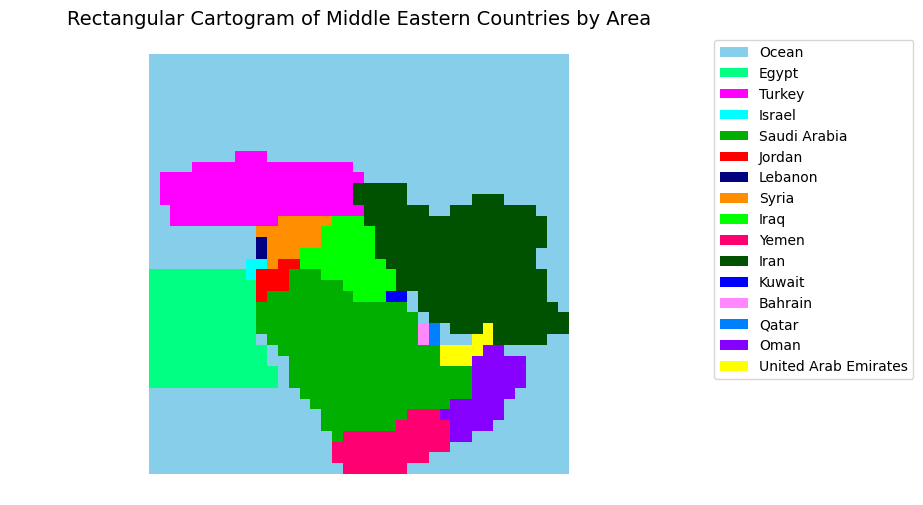

In [30]:

# Create a rectangular cartogram of middle eastern countries by area using our spaced colors
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_aspect('equal', 'datalim')
alpha = 1.0

# Set to keep track of added labels
added_labels = set()

for row_index, row_series in merge_df.iterrows():
    country_name = row_series.country_name
    polygon = row_series.polygon
    if isinstance(polygon, Polygon):
        xs, ys = polygon.exterior.xy
        
        # Only add the label if it hasn't been added yet
        if country_name not in added_labels:
            ax.fill(xs, ys, alpha=alpha, fc=hex_color_dict[country_name], ec='none', label=country_name)
            added_labels.add(country_name)
        else:
            ax.fill(xs, ys, alpha=alpha, fc=hex_color_dict[country_name], ec='none')
    else:
        for geom in polygon.geoms:
            xs, ys = geom.exterior.xy
            
            # Only add the label if it hasn't been added yet
            if country_name not in added_labels:
                ax.fill(xs, ys, alpha=alpha, fc=hex_color_dict[country_name], ec='none', label=country_name)
                added_labels.add(country_name)
            else:
                ax.fill(xs, ys, alpha=alpha, fc=hex_color_dict[country_name], ec='none')

plt.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_aspect("equal")
plt.title("Rectangular Cartogram of Middle Eastern Countries by Area", fontsize=14)
plt.axis("off")
plt.show()

In [71]:

# Find the adjacencies using the original geoms
import networkx as nx
from itertools import combinations

# Initialize an empty graph
G = nx.Graph()

# Add nodes to the graph
for country_name in country_names:
    G.add_node(country_name)

# Get all unique pairs (order doesn't matter)
country_pairs = combinations(country_names, 2)

# For each pair
for pair in country_pairs:
    country_name_from = pair[0]
    geometry_from = geometry_dict[country_name_from]
    country_name_to = pair[1]
    geometry_to = geometry_dict[country_name_to]

    # Check if they touch
    if geometry_from.touches(geometry_to):
        # print(f'{country_name_from} and {country_name_to} border each other')

        # Add an edge between the two countries
        G.add_edge(country_name_from, country_name_to)

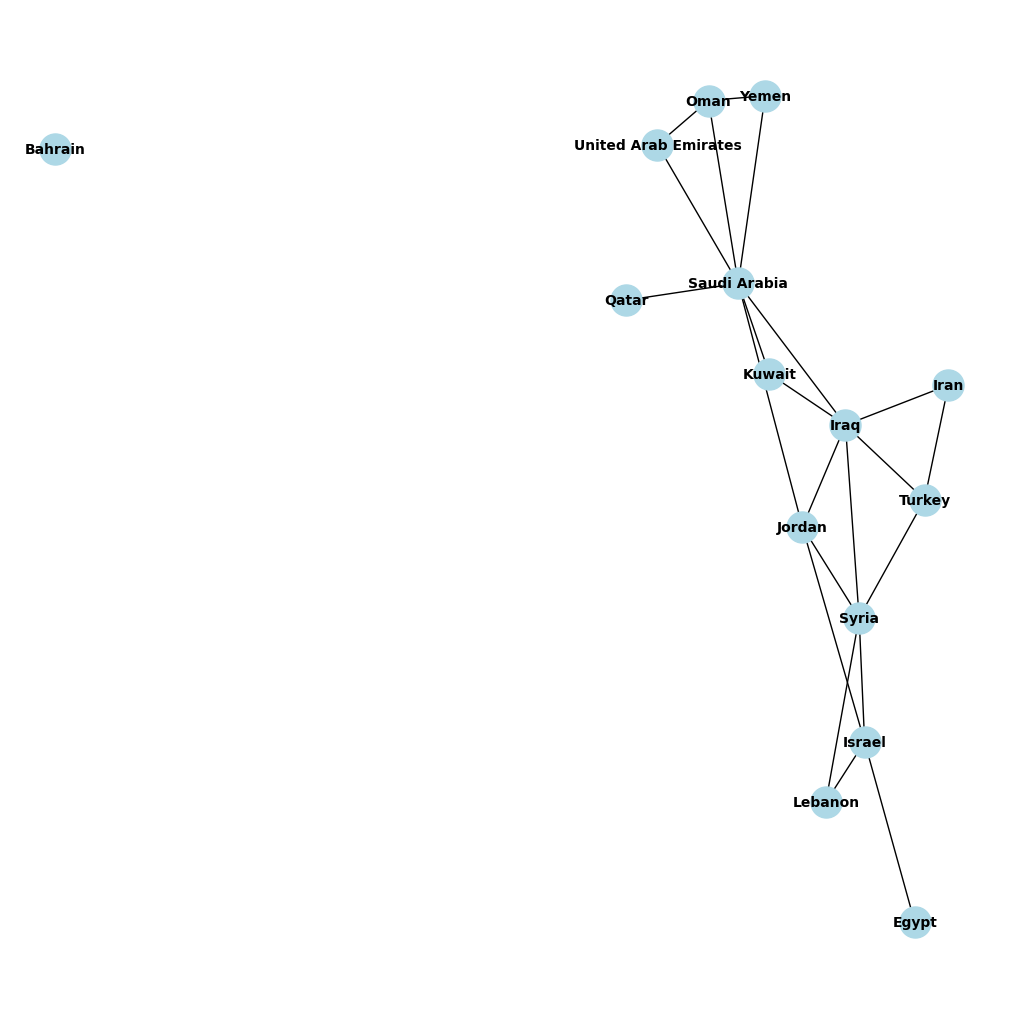

In [72]:

# Draw the graph
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=500, node_color="lightblue", font_size=10, font_weight="bold")
plt.show()

In [73]:

[f'geometry_from.{fn}' for fn in dir(geometry_from) if not fn.startswith('_')]

['geometry_from.almost_equals', 'geometry_from.area', 'geometry_from.boundary', 'geometry_from.bounds', 'geometry_from.buffer', 'geometry_from.centroid', 'geometry_from.contains', 'geometry_from.contains_properly', 'geometry_from.convex_hull', 'geometry_from.coords', 'geometry_from.covered_by', 'geometry_from.covers', 'geometry_from.crosses', 'geometry_from.difference', 'geometry_from.disjoint', 'geometry_from.distance', 'geometry_from.dwithin', 'geometry_from.envelope', 'geometry_from.equals', 'geometry_from.equals_exact', 'geometry_from.exterior', 'geometry_from.from_bounds', 'geometry_from.geom_type', 'geometry_from.geometryType', 'geometry_from.has_z', 'geometry_from.hausdorff_distance', 'geometry_from.interiors', 'geometry_from.interpolate', 'geometry_from.intersection', 'geometry_from.intersects', 'geometry_from.is_closed', 'geometry_from.is_empty', 'geometry_from.is_ring', 'geometry_from.is_simple', 'geometry_from.is_valid', 'geometry_from.length', 'geometry_from.line_interpolat

In [92]:

# for row_index, row_series in merge_df.iterrows():
#     country_name = row_series.country_name
#     polygon = row_series.polygon
#     if isinstance(polygon, Polygon):
#         continue
#     else:
#         break
polygon.svg??

Signature: polygon.svg(scale_factor=1.0, fill_color=None, opacity=None)
Source:   
    def svg(self, scale_factor=1.0, fill_color=None, opacity=None):
        """Returns SVG path element for the Polygon geometry.

        Parameters
        scale_factor : float
            Multiplication factor for the SVG stroke-width.  Default is 1.
        fill_color : str, optional
            Hex string for fill color. Default is to use "#66cc99" if
            geometry is valid, and "#ff3333" if invalid.
        opacity : float
            Float number between 0 and 1 for color opacity. Default value is 0.6
        """
        if self.is_empty:
            return "<g />"
        if fill_color is None:
            fill_color = "#66cc99" if self.is_valid else "#ff3333"
        if opacity is None:
            opacity = 0.6
        exterior_coords = [["{},{}".format(*c) for c in self.exterior.coords]]
        interior_coords = [
            ["{},{}".format(*c) for c in interior.coords] for interior i

In [94]:

# Introspect a Python module to discover available functions and classes programmatically
module_name = 'shapely'
import_call = '''
import shapely'''
sg_functions = nu.get_dir_tree(
   module_name, function_calls=[], contains_str='svg',
   import_call=import_call, recurse_modules=True, recurse_classes=True, level=4,
   verbose=False
)
sorted(sg_functions, key=lambda x: x[::-1])[:6]

[]


----

In [65]:

# Find the adjacencies using the polygon grid
union_polygons_dict = {country_name: MultiPolygon()}
for country_name, country_name_df in merge_df.groupby('country_name'):
    union_polygon = Polygon()
    for polygon in country_name_df.polygon:
        union_polygon = union_polygon.union(polygon)
    union_polygons_dict[country_name] = union_polygon

# For each pair
country_pairs = combinations(country_names, 2)
for pair in country_pairs:
    country_name_from = pair[0]
    union_polygon_from = union_polygons_dict[country_name_from]
    country_name_to = pair[1]
    union_polygon_to = union_polygons_dict[country_name_to]

    # Check if they touch
    if union_polygon_from.touches(union_polygon_to):
        print(f'{country_name_from} and {country_name_to} border each other')

Bahrain and Iran border each other
Bahrain and Qatar border each other
Bahrain and Saudi Arabia border each other
Egypt and Israel border each other
Egypt and Jordan border each other
Egypt and Saudi Arabia border each other
Iran and Iraq border each other
Iran and Kuwait border each other
Iran and Oman border each other
Iran and Qatar border each other
Iran and Saudi Arabia border each other
Iran and Turkey border each other
Iran and United Arab Emirates border each other
Iraq and Jordan border each other
Iraq and Kuwait border each other
Iraq and Saudi Arabia border each other
Iraq and Syria border each other
Iraq and Turkey border each other
Israel and Jordan border each other
Israel and Lebanon border each other
Israel and Syria border each other
Jordan and Saudi Arabia border each other
Jordan and Syria border each other
Kuwait and Saudi Arabia border each other
Lebanon and Syria border each other
Oman and Saudi Arabia border each other
Oman and United Arab Emirates border each ot

In [ ]:

# Get the cmap farthest awawy from sky blue
from cycler import cycler

def get_skyblue_distance():
    """
    Calculate the distance to sky blue of the centroids of the RGB values for all colormaps in matplotlib.

    Returns:
        dict: A dictionary where keys are colormap names and values are the distance from sky blue to the RGB centroids (r, g, b) for each colormap.
    """
    colormaps = plt.colormaps()  # Get all available colormaps
    centroids = {}

    for cmap_name in colormaps:
        # Get the colormap object
        cmap = plt.get_cmap(cmap_name)
        
        # Sample 256 colors from the colormap (standard resolution for colormaps)
        colors = cmap(np.linspace(0, 1, 256))
        
        # Extract the RGB values (ignoring the alpha channel if present)
        rgb_values = colors[:, :3]
        
        # Compute the centroid of the RGB values
        centroid = np.mean(rgb_values, axis=0)
        
        # Store the distance to sky blue in the dictionary
        centroids[cmap_name] = nu.color_distance_from('#87ceeb', tuple(centroid))

    return centroids

# Print the cmap farthest awawy from sky blue and its distance
centroids = get_skyblue_distance()
cmap_tuple = max([(cmap_name, distance) for cmap_name, distance in centroids.items()], key=lambda x: x[1])
print(cmap_tuple)

# Create a cycler out of that cmap
countries_list = sorted(merge_df.country_name.unique())
countries_list.remove('Ocean')
color_cycler = cycler('color', plt.get_cmap(cmap_tuple[0])(np.linspace(0, 1, len(countries_list))))
color_dict = {country_name: face_color_dict['color'] for country_name, face_color_dict in zip(countries_list, color_cycler())}
color_dict['Ocean'] = (0.529, 0.808, 0.922)

In [28]:

[f'geometry.{fn}' for fn in dir(geometry) if not fn.startswith('_')]

['geometry.almost_equals', 'geometry.area', 'geometry.boundary', 'geometry.bounds', 'geometry.buffer', 'geometry.centroid', 'geometry.contains', 'geometry.contains_properly', 'geometry.convex_hull', 'geometry.coords', 'geometry.covered_by', 'geometry.covers', 'geometry.crosses', 'geometry.difference', 'geometry.disjoint', 'geometry.distance', 'geometry.dwithin', 'geometry.envelope', 'geometry.equals', 'geometry.equals_exact', 'geometry.geom_type', 'geometry.geometryType', 'geometry.geoms', 'geometry.has_z', 'geometry.hausdorff_distance', 'geometry.interpolate', 'geometry.intersection', 'geometry.intersects', 'geometry.is_closed', 'geometry.is_empty', 'geometry.is_ring', 'geometry.is_simple', 'geometry.is_valid', 'geometry.length', 'geometry.line_interpolate_point', 'geometry.line_locate_point', 'geometry.minimum_clearance', 'geometry.minimum_rotated_rectangle', 'geometry.normalize', 'geometry.oriented_envelope', 'geometry.overlaps', 'geometry.point_on_surface', 'geometry.project', 'geo

In [27]:

[f'geom.{fn}' for fn in dir(geom) if not fn.startswith('_')]

['geom.almost_equals', 'geom.area', 'geom.boundary', 'geom.bounds', 'geom.buffer', 'geom.centroid', 'geom.contains', 'geom.contains_properly', 'geom.convex_hull', 'geom.coords', 'geom.covered_by', 'geom.covers', 'geom.crosses', 'geom.difference', 'geom.disjoint', 'geom.distance', 'geom.dwithin', 'geom.envelope', 'geom.equals', 'geom.equals_exact', 'geom.exterior', 'geom.from_bounds', 'geom.geom_type', 'geom.geometryType', 'geom.has_z', 'geom.hausdorff_distance', 'geom.interiors', 'geom.interpolate', 'geom.intersection', 'geom.intersects', 'geom.is_closed', 'geom.is_empty', 'geom.is_ring', 'geom.is_simple', 'geom.is_valid', 'geom.length', 'geom.line_interpolate_point', 'geom.line_locate_point', 'geom.minimum_clearance', 'geom.minimum_rotated_rectangle', 'geom.normalize', 'geom.oriented_envelope', 'geom.overlaps', 'geom.point_on_surface', 'geom.project', 'geom.relate', 'geom.relate_pattern', 'geom.representative_point', 'geom.reverse', 'geom.segmentize', 'geom.simplify', 'geom.svg', 'geo

In [141]:

print()
for (country_name, _, _) in country_areas:
    mask_series = countries_df.NAME_EN.isin([country_name])
    for (country_name, geometry), df in countries_df[mask_series].groupby(['NAME_EN', 'geometry']):
        bounds_tuple = geometry.bounds
            
        # Bounds Breakdown:
        minx = bounds_tuple[0]
        maxx = bounds_tuple[2]
        
        # Rectangle Parameters:
        width = maxx - minx

        print(country_name, f'if len(country_name) == {len(country_name)} and width == {width}: fontsize = 46')


Saudi Arabia if len(country_name) == 12 and width == 21.06480021899995: fontsize = 46
Iran if len(country_name) == 4 and width == 19.304764810999927: fontsize = 46
Turkey if len(country_name) == 6 and width == 19.143733518000033: fontsize = 46
Egypt if len(country_name) == 5 and width == 12.210837802999947: fontsize = 46
Yemen if len(country_name) == 5 and width == 11.99454752600002: fontsize = 46
Iraq if len(country_name) == 4 and width == 9.784744052999997: fontsize = 46
Oman if len(country_name) == 4 and width == 7.865959464999946: fontsize = 46
Syria if len(country_name) == 5 and width == 6.653786220999962: fontsize = 46
Jordan if len(country_name) == 6 and width == 4.3426140282045935: fontsize = 46
United Arab Emirates if len(country_name) == 20 and width == 4.8142903650000335: fontsize = 46
Israel if len(country_name) == 6 and width == 1.6397216930000695: fontsize = 46
Kuwait if len(country_name) == 6 and width == 1.9003454770000872: fontsize = 46
Lebanon if len(country_name) ==

In [151]:

def model_func(length, width, a, b, c, d, e):
    return np.maximum(a * length**2 + b * width**2 + c * length * width + d * length + e * width, 1)

In [143]:

# Data for curve fit
lengths = np.array([4, 6, 4, 5, 5, 12, 4, 5, 6, 6, 6, 20, 7, 5, 7])  # Lengths of country names
widths = np.array([19.304764810999927, 19.143733518000033, 9.784744052999997, 
                   12.210837802999947, 11.99454752600002, 21.06480021899995, 
                   7.865959464999946, 6.653786220999962, 4.3426140282045935, 
                   1.6397216930000695, 1.9003454770000872, 4.8142903650000335, 
                   1.5044812079999588, 0.8655598960000361, 0.43934560475753415])  # Widths in pixels
font_sizes = np.array([140, 84, 78, 62, 52, 46, 36, 36, 18, 8, 8, 6, 5, 4, 1])  # Font sizes

In [152]:

from scipy.optimize import curve_fit

# Fit the model to the data
popt, pcov = curve_fit(lambda xy, a, b, c, d, e: model_func(xy[0], xy[1], a, b, c, d, e), 
                       (lengths, widths), font_sizes, 
                       p0=[1, 1, 1, 1, 1])  # Initial guesses for a, b, c, d, e

In [153]:

a, b, c, d, e = popt
print(f"Fitted parameters: a={a}, b={b}, c={c}, d={d}, e={e}")

Fitted parameters: a=0.113248121509901, b=0.07960917897969728, c=-0.6521619640285813, d=-0.7374059853038561, e=7.725629637316294


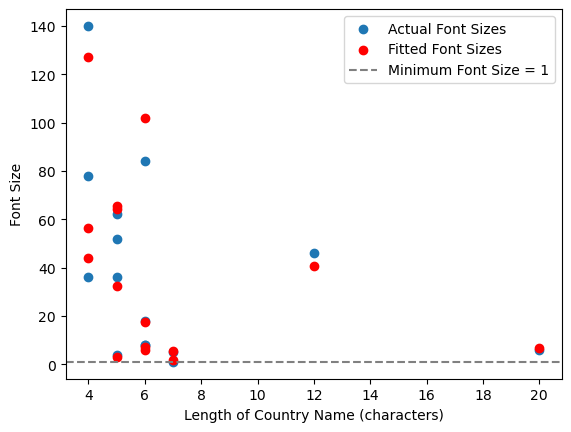

In [154]:

# Predict font sizes
predicted_font_sizes = model_func(lengths, widths, a, b, c, d, e)

# Visualize the results
plt.scatter(lengths, font_sizes, label='Actual Font Sizes')
plt.scatter(lengths, predicted_font_sizes, label='Fitted Font Sizes', color='red')
plt.xlabel('Length of Country Name (characters)')
plt.ylabel('Font Size')
plt.axhline(y=1, color='gray', linestyle='--', label='Minimum Font Size = 1')
plt.legend()
plt.show()

In [ ]:

iraq_dict = nu.get_regexed_dataframe(df, columns_list, country_pattern).dropna(how='all', axis='columns').T.to_dict()[89]

In [46]:

import collections

# Get the country name counts in the data frame columns
columns_sequence = []
for country_name in country_names:
    country_pattern = re.compile(r'\b' + country_name + r'\b')
    columns_sequence.extend(nu.get_regexed_columns(countries_df, country_pattern))
columns_count = collections.Counter(columns_sequence)

# Get the columns that have all the country names
name_columns = []
for cn in [k for k, v in columns_count.items() if v == len(country_names)]:
    df = nu.check_for_typos(country_names, countries_df[cn].unique())
    mask_series = (df.max_similarity < 1.0)
    if mask_series.any():
        display(df[mask_series])
    else:
        name_columns.append(cn)

# Display the column names
name_columns

['ADMIN', 'GEOUNIT', 'SUBUNIT', 'NAME', 'NAME_LONG', 'BRK_NAME', 'NAME_EN']

In [ ]:

df.map?

In [9]:

import glob

bad_file_endings = []
paths_list = [osp.abspath(f) for f in glob.glob('../data/*/ne_10m_admin_0_countries.*', recursive=True)]
formats = []
for file_path in paths_list:
    file_ending = file_path.split('.')[-1].upper()
    try:
        df = gpd.read_file(file_path)
        formats.append(file_ending)
    except Exception as e:
        # print(f"{e.__class__.__name__} error attempting to open {file_ending} in geopandas: {e}")
        print(e)
formats

'C:\Users\daveb\OneDrive\Documents\GitHub\StatsByCountry\data\cpg\ne_10m_admin_0_countries.cpg' not recognized as being in a supported file format. It might help to specify the correct driver explicitly by prefixing the file path with '<DRIVER>:', e.g. 'CSV:path'.
'C:\Users\daveb\OneDrive\Documents\GitHub\StatsByCountry\data\html\ne_10m_admin_0_countries.README.html' not recognized as being in a supported file format. It might help to specify the correct driver explicitly by prefixing the file path with '<DRIVER>:', e.g. 'CSV:path'.
'C:\Users\daveb\OneDrive\Documents\GitHub\StatsByCountry\data\prj\ne_10m_admin_0_countries.prj' not recognized as being in a supported file format. It might help to specify the correct driver explicitly by prefixing the file path with '<DRIVER>:', e.g. 'CSV:path'.
Unable to open C:\Users\daveb\OneDrive\Documents\GitHub\StatsByCountry\data\shp\ne_10m_admin_0_countries.shx or C:\Users\daveb\OneDrive\Documents\GitHub\StatsByCountry\data\shp\ne_10m_admin_0_coun

['DBF', 'ZIP']

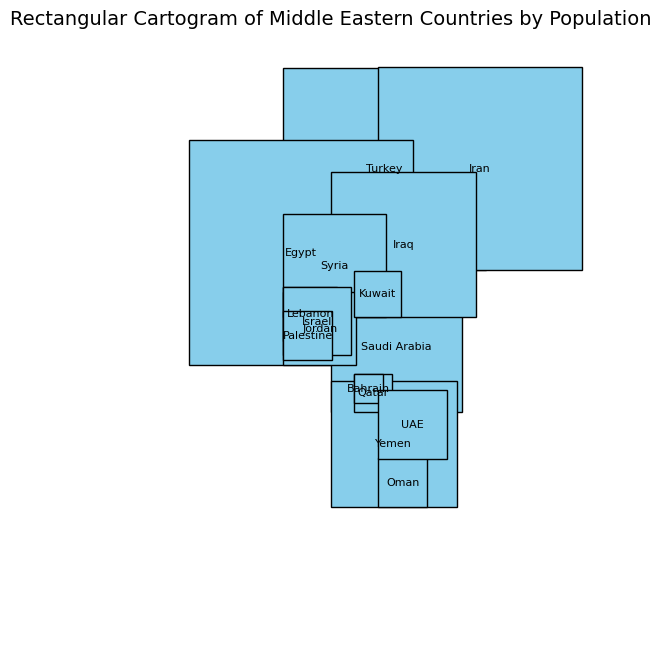

In [9]:

# Example population data for Middle Eastern countries
population_data = {
    "Turkey": 85000000,
    "Iran": 86000000,
    "Egypt": 105000000,
    "Saudi Arabia": 36000000,
    "Iraq": 44000000,
    "Yemen": 33000000,
    "Syria": 22000000,
    "Jordan": 11000000,
    "Lebanon": 6000000,
    "Israel": 9600000,
    "Palestine": 5000000,
    "Oman": 5000000,
    "Kuwait": 4500000,
    "Qatar": 3000000,
    "Bahrain": 1700000,
    "UAE": 10000000,
}

# Normalize population data for rectangle sizes
total_population = sum(population_data.values())
normalized_data = {k: v / total_population for k, v in population_data.items()}

# Define approximate positions for each country (manually adjusted)
positions = {
    "Turkey": (5, 8),
    "Iran": (7, 8),
    "Egypt": (3, 6),
    "Saudi Arabia": (6, 5),
    "Iraq": (6, 7),
    "Yemen": (6, 3),
    "Syria": (5, 7),
    "Jordan": (5, 6),
    "Lebanon": (5, 6.5),
    "Israel": (5, 6.2),
    "Palestine": (5, 6.1),
    "Oman": (7, 3),
    "Kuwait": (6.5, 7),
    "Qatar": (6.5, 5),
    "Bahrain": (6.5, 5.2),
    "UAE": (7, 4),
}


for country, norm_pop in normalized_data.items():
    x, y = positions[country]  # Get the position
    size = norm_pop * 100  # Scale size based on population
    width = size ** 0.5  # Width of the rectangle
    height = size ** 0.5  # Height of the rectangle

    # Draw the rectangle
    rect = patches.Rectangle((x, y), width, height, edgecolor="black", facecolor="skyblue")
    ax.add_patch(rect)

    # Add country name
    ax.text(x + width / 2, y + height / 2, country, ha="center", va="center", fontsize=8)

In [ ]:

import geopandas as gpd
from matplotlib.patches import Rectangle

# Example population data for Middle Eastern countries (replace with actual data)
population_data = {
    "Turkey": 85000000,
    "Iran": 86000000,
    "Egypt": 105000000,
    "Saudi Arabia": 36000000,
    "Iraq": 44000000,
    "Yemen": 33000000,
    "Syria": 22000000,
    "Jordan": 11000000,
    "Lebanon": 6000000,
    "Israel": 9600000,
    "Palestine": 5000000,
    "Oman": 5000000,
    "Kuwait": 4500000,
    "Qatar": 3000000,
    "Bahrain": 1700000,
    "UAE": 10000000,
}

# Normalize population data for rectangle sizes
total_population = sum(population_data.values())
normalized_data = {k: v / total_population for k, v in population_data.items()}

# Load geographic data for Middle Eastern countries (replace with actual shapefile or GeoJSON)
# Example: 'middle_east.geojson' should contain country boundaries
geo_data = gpd.read_file("middle_east.geojson")

# Create a plot
fig, ax = plt.subplots(figsize=(12, 10))

# Iterate through countries and draw rectangles
for _, row in geo_data.iterrows():
    country_name = row["name"]  # Replace with the column name for country names in your GeoJSON
    if country_name in normalized_data:
        # Get the centroid of the country for positioning
        centroid = row.geometry.centroid
        x, y = centroid.x, centroid.y

        # Scale the rectangle size based on population
        size = normalized_data[country_name] * 100  # Adjust scaling factor as needed
        width = size
        height = size / 2  # Adjust aspect ratio as needed

        # Draw the rectangle
        rect = Rectangle((x - width / 2, y - height / 2), width, height, edgecolor="black", facecolor="skyblue")
        ax.add_patch(rect)

        # Add country name as a label
        ax.text(x, y, country_name, ha="center", va="center", fontsize=8)

# Plot the original country boundaries for reference
geo_data.boundary.plot(ax=ax, color="gray", linewidth=0.5)

# Adjust plot limits and title
ax.set_xlim(geo_data.total_bounds[0], geo_data.total_bounds[2])
ax.set_ylim(geo_data.total_bounds[1], geo_data.total_bounds[3])
ax.set_aspect("equal")
plt.title("Rectangular Cartogram of Middle Eastern Countries by Population", fontsize=14)
plt.axis("off")
plt.show()

In [5]:

gpd.read_file?

Signature:
gpd.read_file(
    filename,
    bbox=None,
    mask=None,
    columns=None,
    rows=None,
    engine=None,
    **kwargs,
)
Docstring:
Returns a GeoDataFrame from a file or URL.

Parameters
----------
filename : str, path object or file-like object
    Either the absolute or relative path to the file or URL to
    be opened, or any object with a read() method (such as an open file
    or StringIO)
bbox : tuple | GeoDataFrame or GeoSeries | shapely Geometry, default None
    Filter features by given bounding box, GeoSeries, GeoDataFrame or a shapely
    geometry. With engine="fiona", CRS mis-matches are resolved if given a GeoSeries
    or GeoDataFrame. With engine="pyogrio", bbox must be in the same CRS as the
    dataset. Tuple is (minx, miny, maxx, maxy) to match the bounds property of
    shapely geometry objects. Cannot be used with mask.
mask : dict | GeoDataFrame or GeoSeries | shapely Geometry, default None
    Filter for features that intersect with the given dict-l

In [11]:

file_path = osp.abspath(osp.join(nu.data_folder, 'dbf', 'ne_10m_admin_0_countries.dbf'))
df = gpd.read_file(file_path)
country_name = 'Iraq'
country_pattern = re.compile(r'\b' + country_name + r'\b')
columns_list = nu.get_regexed_columns(df, country_pattern)
nu.get_regexed_dataframe(df, columns_list, country_pattern).dropna(how='all', axis='columns').T.to_dict()[89]

{'featurecla': 'Admin-0 country', 'scalerank': 0, 'LABELRANK': 3, 'SOVEREIGNT': 'Iraq', 'SOV_A3': 'IRQ', 'ADM0_DIF': 0, 'LEVEL': 2, 'TYPE': 'Sovereign country', 'TLC': '1', 'ADMIN': 'Iraq', 'ADM0_A3': 'IRQ', 'GEOU_DIF': 0, 'GEOUNIT': 'Iraq', 'GU_A3': 'IRQ', 'SU_DIF': 0, 'SUBUNIT': 'Iraq', 'SU_A3': 'IRQ', 'BRK_DIFF': 0, 'NAME': 'Iraq', 'NAME_LONG': 'Iraq', 'BRK_A3': 'IRQ', 'BRK_NAME': 'Iraq', 'ABBREV': 'Iraq', 'POSTAL': 'IRQ', 'FORMAL_EN': 'Republic of Iraq', 'NAME_CIAWF': 'Iraq', 'NAME_SORT': 'Iraq', 'MAPCOLOR7': 1, 'MAPCOLOR8': 4, 'MAPCOLOR9': 3, 'MAPCOLOR13': 1, 'POP_EST': 39309783.0, 'POP_RANK': 15, 'POP_YEAR': 2019, 'GDP_MD': 234094, 'GDP_YEAR': 2019, 'ECONOMY': '6. Developing region', 'INCOME_GRP': '4. Lower middle income', 'FIPS_10': 'IZ', 'ISO_A2': 'IQ', 'ISO_A2_EH': 'IQ', 'ISO_A3': 'IRQ', 'ISO_A3_EH': 'IRQ', 'ISO_N3': '368', 'ISO_N3_EH': '368', 'UN_A3': '368', 'WB_A2': 'IQ', 'WB_A3': 'IRQ', 'WOE_ID': 23424855, 'WOE_ID_EH': 23424855, 'WOE_NOTE': 'Exact WOE match as country', 'AD